In [1]:
import s4bi
import matplotlib.pyplot as plt
from importlib import reload
from scipy import constants
from astropy.cosmology import Planck15
import qubic
from qubic import mcmc
import healpy as hp
import numpy as np
import os
import CMBS4
import qubicplus
#import fgbuster
import fgbuster
center = qubic.equ2gal(0, -57)
from fgbuster.component_model import (CMB, Dust, Dust_2b, Synchrotron, AnalyticComponent)
from fgbuster import basic_comp_sep, get_instrument
# If there is not this command, the kernel shut down every time..
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import pickle

def separate(comp, instr, maps_to_separate, print_option=False):
    solver_options = {'eps':1e-5}
    solver_options['disp'] = False
    fg_args = comp, instr, maps_to_separate
    fg_kwargs = {'method': 'L-BFGS-B', 'options': solver_options}
    try:
        res = fgbuster.basic_comp_sep(*fg_args, **fg_kwargs)
    except KeyError:
        fg_kwargs['options']['disp'] = False
        res = fgbuster.basic_comp_sep(*fg_args, **fg_kwargs)
    if print_option:
        print()
        print("message:", res.message)
        print("success:", res.success)
        print("result:", res.x)
        
    return res

nside=256
def get_coverage(fsky, nside, center_radec=[0., -57.]):
    center = qubic.equ2gal(center_radec[0], center_radec[1])
    uvcenter = np.array(hp.ang2vec(center[0], center[1], lonlat=True))
    uvpix = np.array(hp.pix2vec(nside, np.arange(12*nside**2)))
    ang = np.arccos(np.dot(uvcenter, uvpix))
    indices = np.argsort(ang)
    okpix = ang < -1
    okpix[indices[0:int(fsky * 12*nside**2)]] = True
    mask = np.zeros(12*nside**2)
    mask[okpix] = 1
    return mask

covmap = get_coverage(0.03, nside)

pkl_file = open('S4_dict.pkl', 'rb')
S4_dict = pickle.load(pkl_file)
pkl_file.close()
pkl_file = open('BI_dict.pkl', 'rb')
BI_dict = pickle.load(pkl_file)
pkl_file.close()

Before we explore the component separation with FG-Buster for a simple model of dust (d0 in PySM) which leads to a modified black body with temperature $T$ and a spectral index $\beta_d$. Let's assume now a more complex model of dust. We impose now two index $\beta$ which caracterize SED between a break frequency $\nu_{break}$. 

We modify FG-Buster before in order to compute a SED with twos differents slopes. Here a defition which compute those SED.

In [2]:
# analytic expression 
analytic_expr=s4bi.double_beta_dust_FGB_Model()

betadown=1.
betaup=2.
beta1 = 1.54

def sed(analytic_expr, nus, beta0, beta1, temp=20, hok=constants.h * 1e9 / constants.k, nubreak=200, nu0=100):
    sed_expr = AnalyticComponent(analytic_expr, 
                             nu0=nu0, 
                             beta_d0=beta0, 
                             beta_d1=beta1, 
                             temp=temp,
                             nubreak=nubreak, 
                             h_over_k = hok)
    return nus, sed_expr.eval(nus)
nus=np.linspace(10, 400, 200)
nb=100
nus, sed1b = sed(analytic_expr, nus, beta1, beta1, nubreak=nb)
nus, sed2b_down = sed(analytic_expr, nus, betadown, beta1, nubreak=nb)
nus, sed2b_up = sed(analytic_expr, nus, betaup, beta1, nubreak=nb)

We construct SED caracterize by twos scalar $\beta$. We can now construct maps which follow those law.

In [15]:
reload(qubicplus)

dust_s4, dust_s4_noiseless, _  = qubicplus.BImaps({'dust':'d0'}, S4_dict).getskymaps(same_resol=1, 
                                                        iib=False, 
                                                        verbose=True, 
                                                        coverage=covmap, 
                                                        noise=True, 
                                                        signoise=1., 
                                                        beta=[])

dust_s4_modified, dust_s4_modified_noiseless, _  = qubicplus.BImaps({'dust':'d02b'}, S4_dict).getskymaps(same_resol=1, 
                                                        iib=False, 
                                                        verbose=False, 
                                                        coverage=covmap, 
                                                        noise=True, 
                                                        signoise=1., 
                                                        beta=[1., 1.54, 100])

cmbdust_s4_modified, cmbdust_s4_modified_noiseless, _  = qubicplus.BImaps({'cmb':42, 'dust':'d02b'}, S4_dict).getskymaps(same_resol=1, 
                                                        iib=False, 
                                                        verbose=False, 
                                                        coverage=covmap, 
                                                        noise=True, 
                                                        signoise=1., 
                                                        beta=[1., 1.54, 100])

cmbdust_s4, cmbdust_s4_noiseless, _  = qubicplus.BImaps({'cmb':42, 'dust':'d0'}, S4_dict).getskymaps(same_resol=1, 
                                                        iib=False, 
                                                        verbose=False, 
                                                        coverage=covmap, 
                                                        noise=True, 
                                                        signoise=1., 
                                                        beta=[])


    FWHM : [1. 1. 1. 1. 1. 1. 1. 1. 1.] deg 
    nus : [ 20.  30.  40.  85.  95. 145. 155. 220. 270.] GHz 
    Bandwidth : [ 5.   9.  12.  20.4 22.8 31.9 34.1 48.4 59.4] GHz


Model : d0 -> Spectral index beta is constant on the sky (set to 1.54)
Convolved to 1.00 deg
Convolved to 1.00 deg
Convolved to 1.00 deg
Convolved to 1.00 deg
Convolved to 1.00 deg
Convolved to 1.00 deg
Convolved to 1.00 deg
Convolved to 1.00 deg
Convolved to 1.00 deg


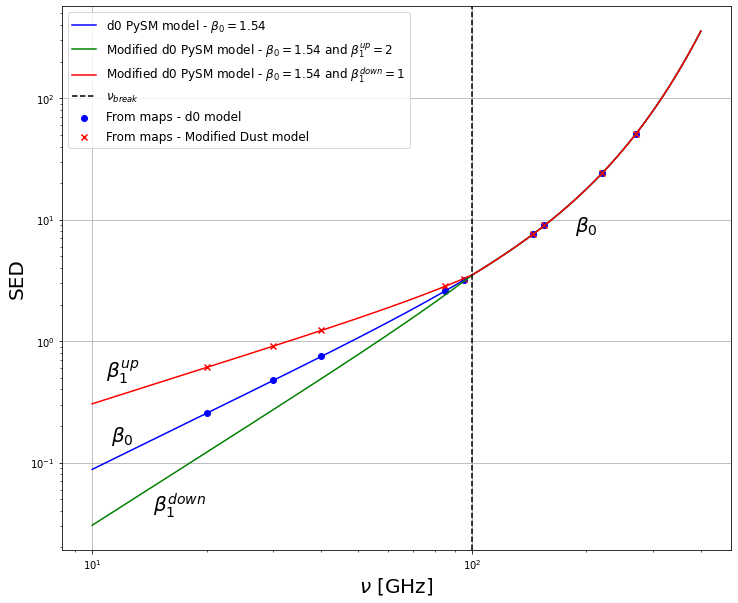

In [16]:
thr = 0.1
mymask = (covmap > (np.max(covmap)*thr)).astype(int)
pixok = mymask > 0

plt.figure(figsize=(12, 10))
plt.loglog(nus, sed1b*3.5, '-b', label = r'd0 PySM model - $\beta_0 = 1.54$')
plt.loglog(nus, sed2b_up*3.5, '-g', label = r'Modified d0 PySM model - $\beta_0 = 1.54$ and $\beta^{up}_1 = 2$')
plt.loglog(nus, sed2b_down*3.5, '-r', label = r'Modified d0 PySM model - $\beta_0 = 1.54$ and $\beta^{down}_1 = 1$')
plt.scatter(S4_dict['frequency'], np.mean(dust_s4_noiseless[:, :, pixok], axis=2)[:, 0], color='blue', 
                        marker = 'o', label='From maps - d0 model')
plt.scatter(S4_dict['frequency'], np.mean(dust_s4_modified_noiseless[:, :, pixok], axis=2)[:, 0], color='red', 
                        marker = 'x', label='From maps - Modified Dust model')

plt.annotate(r'$\beta^{up}_{1}$', fontsize = 20, xy=(12, 0.5), ha='center')
plt.annotate(r'$\beta_{0}$', fontsize = 20, xy=(12, 0.15), ha='center')
plt.annotate(r'$\beta^{down}_{1}$', fontsize = 20, xy=(17, 0.04), ha='center')
plt.annotate(r'$\beta_{0}$', fontsize = 20, xy=(200, 8), ha='center')

plt.xlabel(r'$\nu$ [GHz]', fontsize=20)
plt.ylabel(r'SED', fontsize=20)
plt.axvline(nb, ls='--', color='black', label=r'$\nu_{break}$')
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [17]:
comp_modified = [Dust_2b(nu0=353, nubreak=100), CMB()]
comp = [Dust(nu0=100), CMB()]

# Define instrument
instr = get_instrument('CMBS4')
instr.fwhm = np.ones(9)*1*60

In [19]:
#Component Separation

r_s4_modified=separate(comp_modified, instr, cmbdust_s4_modified[:, :, pixok])
r_s4=separate(comp, instr, cmbdust_s4[:, :, pixok])

print("   beta_d = {:.6f} T = {:.6f}".format(r_s4.x[0], r_s4.x[1]))
print("   beta_d0 = {:.6f} beta_d1 = {:.6f} T = {:.6f}".format(r_s4_modified.x[0], r_s4_modified.x[1], r_s4_modified.x[2]))

   beta_d = 1.540264 T = 20.000004
   beta_d0 = 1.002495 beta_d1 = 1.540673 T = 19.985920


OK, for CMB_S4, it seems that we could recover all those parameters, let's check for the bolometric interferometry technology.

In [ ]:
reload(qubicplus)

dust_bi, dust_bi_noiseless, _  = qubicplus.BImaps({'dust':'d0'}, BI_dict).getskymaps(same_resol=1, 
                                                        iib=False, 
                                                        verbose=False, 
                                                        coverage=covmap, 
                                                        noise=True, 
                                                        signoise=1., 
                                                        beta=[])

dust_bi_modified, dust_bi_modified_noiseless, _  = qubicplus.BImaps({'dust':'d02b'}, BI_dict).getskymaps(same_resol=1, 
                                                        iib=False, 
                                                        verbose=False, 
                                                        coverage=covmap, 
                                                        noise=True, 
                                                        signoise=1., 
                                                        beta=[1., 1.54, 100])

cmbdust_bi_modified, cmbdust_modified_noiseless, _  = qubicplus.BImaps({'cmb':42, 'dust':'d02b'}, BI_dict).getskymaps(same_resol=1, 
                                                        iib=False, 
                                                        verbose=False, 
                                                        coverage=covmap, 
                                                        noise=True, 
                                                        signoise=1., 
                                                        beta=[1., 1.54, 100])

cmbdust_bi, cmbdust_noiseless, _  = qubicplus.BImaps({'cmb':42, 'dust':'d0'}, BI_dict).getskymaps(same_resol=1, 
                                                        iib=False, 
                                                        verbose=False, 
                                                        coverage=covmap, 
                                                        noise=True, 
                                                        signoise=1., 
                                                        beta=[1., 1.54, 100])

In [ ]:
thr = 0.1
mymask = (covmap > (np.max(covmap)*thr)).astype(int)
pixok = mymask > 0

plt.figure(figsize=(12, 10))
plt.loglog(nus, sed1b*3.5, '-b', label = r'd0 PySM model - $\beta_0 = 1.54$')
plt.loglog(nus, sed2b_up*3.5, '-g', label = r'Modified d0 PySM model - $\beta_0 = 1.54$ and $\beta^{up}_1 = 2$')
plt.loglog(nus, sed2b_down*3.5, '-r', label = r'Modified d0 PySM model - $\beta_0 = 1.54$ and $\beta^{down}_1 = 1$')
plt.scatter(BI_dict['frequency'], np.mean(dust_noiseless[:, :, pixok], axis=2)[:, 0], color='blue', 
                        marker = 'o', label='From maps - d0 model')
plt.scatter(BI_dict['frequency'], np.mean(dust_modified_noiseless[:, :, pixok], axis=2)[:, 0], color='red', 
                        marker = 'x', label='From maps - Modified Dust model')

plt.annotate(r'$\beta^{up}_{1}$', fontsize = 20, xy=(12, 0.5), ha='center')
plt.annotate(r'$\beta_{0}$', fontsize = 20, xy=(12, 0.15), ha='center')
plt.annotate(r'$\beta^{down}_{1}$', fontsize = 20, xy=(17, 0.04), ha='center')
plt.annotate(r'$\beta_{0}$', fontsize = 20, xy=(200, 8), ha='center')

plt.xlabel(r'$\nu$ [GHz]', fontsize=20)
plt.ylabel(r'SED', fontsize=20)
plt.axvline(nb, ls='--', color='black', label=r'$\nu_{break}$')
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
comp_modified = [Dust_2b(nu0=100, nubreak=100), CMB()]
comp = [Dust(nu0=100), CMB()]

thr = 0.1
mymask = (covmap > (np.max(covmap)*thr)).astype(int)
pixok = mymask > 0

instr = get_instrument('Qubic+')
instr.fwhm = np.ones(45)*1*60

In [ ]:
r_bi_modified=separate(comp_modified, instr, cmbdust_bi_modified[:, :, pixok])
r_bi=separate(comp, instr, cmbdust_bi[:, :, pixok])

print("   beta_d = {:.6f} T = {:.6f}".format(r_bi.x[0], r_bi.x[1]))
print("   beta_d0 = {:.6f} beta_d1 = {:.6f} T = {:.6f}".format(r_bi_modified.x[0], r_bi_modified.x[1], r_bi_modified.x[2]))

In [ ]:
def scaling_factor(maps, nus, analytic_expr, beta0, beta1, nubreak):
    nb_nus = maps.shape[0]
    newmaps = np.zeros(maps.shape)
    #print(sed1b)
    for i in range(nb_nus):
        _, sed1b = sed(analytic_expr, nus[i], beta1, beta1, nu0=nus[i], nubreak=nubreak)
        _, sed2b = sed(analytic_expr, nus[i], beta0, beta1, nu0=nus[i], nubreak=nubreak)
        print('nu is {} & Scaling factor is {:.8f}'.format(nus[i], sed2b))
        newmaps[i] = maps[i] * sed2b
    return newmaps, sed1b, sed2b

thr = 0.1
mymask = (covmap > (np.max(covmap)*thr)).astype(int)
pixok = mymask > 0

nb=100
new_dustS4, _, _ = scaling_factor(dustS4, S4_dict['frequency'], analytic_expr, 0.5, 1.54, nubreak=nb)

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(S4_dict['frequency'], np.mean(dustS4[:, :, pixok], axis=2)[:, 0], label = 'd0 PySM model')
plt.scatter(S4_dict['frequency'], np.mean(new_dustS4[:, :, pixok], axis=2)[:, 0], label = 'Modified d0 PySM model with twos betas')
nus=np.linspace(1, 300, 200)
#plt.loglog(nus, sed1b*18, label = 'd0 PySM model')
#plt.loglog(nus, sed2b*(25), label = 'Modified d0 PySM model with twos betas')

plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.xlabel(r'$\nu$ [GHz]', fontsize=15)
plt.ylabel(r'SED', fontsize=15)
plt.xlim(10, 290)
plt.axvline(nb, ls='--', color='black', label=r'$\nu_{break}$')
plt.legend(fontsize=15)
plt.show()

In [ ]:
comp = [Dust_2b(nu0=110, nubreak=nb)]

instr = get_instrument('CMBS4')
instr.fwhm = np.ones(9)*1*60
r_s4_withoutiib=separate(comp, instr, new_dustS4[:, :, pixok])
print("   ", r_s4_withoutiib.x)

In [ ]:
# let's try with QUBIC+

skyconfig = {'cmb':42}

_, cmbBI, _ = qubicplus.QUBICplus(skyconfig, BI_dict).getskymaps(
                                                        same_resol=1, 
                                                        iib=False, 
                                                        verbose=True, 
                                                        coverage=covmap, 
                                                        noise=True, 
                                                        signoise=1.)

_, dustBI, _ = qubicplus.QUBICplus({}, BI_dict).getskymaps(
                                                        same_resol=1, 
                                                        iib=False, 
                                                        verbose=True, 
                                                        coverage=covmap, 
                                                        noise=True, 
                                                        signoise=1., 
                                                        beta=[1., 1.54, 100])

nb=100
#new_dustBI, _, _ = scaling_factor(dustBI, BI_dict['frequency'], analytic_expr, 0.5, 1.54, nubreak=nb)

plt.figure(figsize=(12, 10))
plt.scatter(BI_dict['frequency'], np.mean(dustBI[:, :, pixok], axis=2)[:, 0], label = 'd0 PySM model')
plt.scatter(BI_dict['frequency'], np.mean(new_dustBI[:, :, pixok], axis=2)[:, 0], label = 'Modified d0 PySM model with twos betas')
nus=np.linspace(1, 300, 200)
#plt.loglog(nus, sed1b*18, label = 'd0 PySM model')
#plt.loglog(nus, sed2b*(25), label = 'Modified d0 PySM model with twos betas')

plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.xlabel(r'$\nu$ [GHz]', fontsize=15)
plt.ylabel(r'SED', fontsize=15)
plt.xlim(10, 290)
plt.axvline(nb, ls='--', color='black', label=r'$\nu_{break}$')
plt.legend(fontsize=15)
plt.show()

In [ ]:
maps = cmbBI + dustBI

In [ ]:
comp = [Dust_2b(nu0=110, nubreak=nb), CMB()]

instr = get_instrument('Qubic+')
instr.fwhm = np.ones(45)*1*60
r_bi_withoutiib=separate(comp, instr, maps[:, :, pixok])
print("   ", r_bi_withoutiib.x)

In [ ]:
reload(qubicplus)

skyconfig = {'cmb':42}
dustS4, dustS4_n, _ = qubicplus.QUBICplus(skyconfig, BI_dict).getskymaps(
                                                        same_resol=0.1, 
                                                        iib=False, 
                                                        verbose=True, 
                                                        coverage=covmap, 
                                                        noise=True, 
                                                        signoise=1.,
                                                        beta=[1., 1.54, 200])

In [ ]:
comp = [Dust_2b(nu0=100, temp=20., nubreak=200)]

instr = get_instrument('Qubic+')
instr.fwhm = np.ones(45)*1*60
r_bi_withoutiib=separate(comp, instr, dustS4[:, :, pixok])
print("   ", r_bi_withoutiib.x)

In [ ]:
r_bi_withoutiib.x[0]